In [48]:

pip install tpot

     |████████████████████████████████| 87 kB 9.8 MB/s             
     |████████████████████████████████| 160 kB 58.3 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=10e6ce561bdff2dd786ce8ea1db63e1a00dab4102a29a9221810043e6c74e8de
  Stored in directory: /home/datalore/.cache/pip/wheels/a8/bb/8f/6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install auto-sklearn

     |████████████████████████████████| 6.4 MB 21.2 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 24.9 MB 65.2 MB/s            
     |████████████████████████████████| 1.1 MB 44.9 MB/s            
     |████████████████████████████████| 856 kB 39.4 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 4.9 MB 25.7 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 3.9 MB 59.1 MB/s            
     |████████████████████████████████| 260 kB 61.9 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.9 MB 63.7 MB/s            
     |████████████████████████████████| 136 kB 63.5 MB/s            
     |████████████████████████████████| 55 kB 6.8 MB/s             
     |████████████████████████████████| 322 kB 62.8 MB/s            
     |████████████████████████████████| 283 kB 51.5 MB/s     

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn import model_selection
import seaborn as sns
import random
from sklearn.model_selection import KFold

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tpot import TPOTRegressor
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error

In [2]:
def show_correlation_coefficient(data_df,method):
    sns.set(font_scale=1)
    df_corr = data_df.corr(method=method, min_periods=1)
    plt.figure(figsize=(18,14))
    sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, annot=True,
            linewidths=0.5)

In [3]:
def show_distribution_diagram(data, name):
    sns.set(font_scale=1)
    variable = data[name].fillna(data.mean())
    sns.displot(data=variable, kind="kde", multiple="stack")
    plt.show()

In [4]:
class YieldStressPredict:
    def __init__(self,tpot,auto_sklearn=None):
        self.tpot = tpot
        self.auto_sklearn = auto_sklearn
        

    def fit(self, X_train, y_train):
        self.tpot = self.tpot.fit(X_train,y_train)
        self.auto_sklearn = self.auto_sklearn.fit(X_train,y_train)
        self.X_train = X_train
        self.y_train = y_train
        

    def get_best_pipeline(self,name):
        self.tpot.export("tpot_export"+name+".py")
        result = self.auto_sklearn.cv_results_
        df = pd.DataFrame(result)
        df.to_csv("autosklearn" + name + ".csv")
        

    def predict(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.tpot_predict = self.tpot.predict(X_test)
        self.auto_sklearn_predict = self.auto_sklearn.predict(X_test)

    def mean_squared_error(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict

        mse = mean_squared_error(self.y_test, y_predict)
        return mse
    def mean_absolute_error(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict
        mae = mean_absolute_error(self.y_test,y_predict)
        return  mae
    def r2_score(self,name):
        y_predict = []
        if name == 'tpot':
            y_predict = self.tpot_predict
        elif name == 'auto_sklearn':
            y_predict = self.auto_sklearn_predict
        r2 = r2_score(self.y_test, y_predict)
        return r2
    
    def show_deviance_diagrams(self,model_name):
        test_score = np.zeros((self.params["n_estimators"],), dtype=np.float64)
        for i, y_pred in enumerate(self.reg.staged_predict(self.X_test)):
            test_score[i] = self.reg.loss_(self.y_test, y_pred)

        fig = plt.figure(figsize=(6, 6))
        plt.subplot(1, 1, 1)
        plt.title("Deviance of: " + model_name)
        plt.plot(
            np.arange(self.params["n_estimators"]) + 1, self.reg.train_score_, "b-", label="Training Set Deviance", )
        plt.plot(np.arange(self.params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
        plt.legend(loc="upper right")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance")
        fig.tight_layout()
        plt.show()

    def show_tpot_features_importance(self,model_name):
        feature_names = self.X_train.columns
        best_model = self.tpot.fitted_pipeline_.steps[-1][1]
        best_model.fit(self.X_train,self.y_train)
        feature_importance = best_model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + 0.5
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.barh(pos, feature_importance[sorted_idx], align="center")
        plt.yticks(pos, np.array(feature_names)[sorted_idx])
        plt.title("Feature Importance (MDI) of: " + model_name)

        result = permutation_importance(
            best_model, self.X_test, self.y_test, n_repeats=10, random_state=13, n_jobs=2
        )
        sorted_idx = result.importances_mean.argsort()
        plt.subplot(1, 2, 2)
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(feature_names)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        fig.tight_layout()
        plt.show()


def train_test_split(data_df, target_feature_name, test_size, random_state):
    X = data_df.drop([target_feature_name], axis=1)
    y = data_df[target_feature_name]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X_train, X_test, y_train, y_test)




	
    

In [19]:
def save_y_predict(y_true, tpot_predict, auto_predict, filename):
    dt = pd.read_csv(filename)
    for i in range(0,len(y_true)):
        print(y_true[i])
        newrow = {'y_true': y_true[i],
                  'tpot_predict': tpot_predict[i],
                  'auto_sklearn_predict': auto_predict[i],
                  'tpot_error': abs(tpot_predict[i] - y_true[i]) / y_true[i],
                  'auto_sklearn_error': abs(auto_predict[i] - y_true[i]) / y_true[i]}
        dt = dt.append(newrow)

    # dt['y_true'] = dt['y_true'].add(y_true)
    # dt['tpot_predict']= dt['tpot_predict'].add(tpot_predict)
    # dt['auto_sklearn_predict']= dt['auto_sklearn_predict'].add(auto_predict)
    # dt['tpot_error']=dt['tpot_error'].add([(abs(e1-e2)/e1)  for (e1, e2) in zip(y_true, tpot_predict)])
    # dt['auto_sklearn_error']=dt['auto_sklearn_error'].add([(abs(e1-e2)/e1)  for (e1, e2) in zip(y_true, tpot_predict)])
    dt.to_csv(filename, index=False)


def compare_frameworks(ys_prediction, data_df, target_feature, test_size,
                       number_of_iterations, file_stats_name, y_stats_filename):
    filename = file_stats_name
    stats_df = pd.read_csv(filename)
    row_number = len(stats_df.index)
    start_index = 0
    if row_number == 0:
        #
        stats_df.columns = ["Times", "random_state", "MAE", "MSE", "R2", "type"]
        stats_df.to_csv(filename)
    if row_number > 1:
        first_column = stats_df.iloc[:, 0]
        start_index = first_column[row_number - 1] + 1
    for i in range(number_of_iterations):
        random_state = random.randint(1, 12341251)
        X_train, X_test, y_train, y_test = train_test_split(data_df, target_feature, test_size, random_state)

        # traings model
        ys_prediction.fit(X_train, y_train)
        # predict test data
        ys_prediction.predict(X_test, y_test)
        y_test_df = pd.DataFrame(y_test, columns=['y_test'])
        save_y_predict(y_test_df['y_test'], ys_prediction.tpot_predict,
                       ys_prediction.auto_sklearn_predict, y_stats_filename)

        mae = ys_prediction.mean_absolute_error(name='tpot')
        mse = ys_prediction.mean_squared_error(name='tpot')
        r2 = ys_prediction.r2_score(name='tpot')
        ys_prediction.get_best_pipeline(str(i + start_index))
        newline1 = "{},{},{},{},{},{}\n".format(i + start_index, random_state, mae, mse, r2, 'tpot')
        mae = ys_prediction.mean_absolute_error(name='auto_sklearn')
        mse = ys_prediction.mean_squared_error(name='auto_sklearn')
        r2 = ys_prediction.r2_score(name='auto_sklearn')
        newline2 = "{},{},{},{},{},{}\n".format(i + start_index, random_state, mae, mse, r2, 'auto_sklearn')

        with open(filename, 'a') as f:
            f.write(newline1)
            f.write(newline2)
    return ys_prediction
            

In [9]:
filename = "YieldStress_database.csv"
fw_stats_filename = "framework_stats.csv"
y_predict_stats_filename = "y_predict_stats.csv"
target_feature = "YS (MPa)"
data_df = pd.read_csv(filename)
data_df = data_df.iloc[:, 1:]



In [21]:
x_train,X_test,y_train,y_test = train_test_split(data_df,target_feature,0.3,120)
save_y_predict(y_test,y_test,y_test,y_predict_stats_filename)

1862.0


TypeError: TypeError: Can only append a dict if ignore_index=True

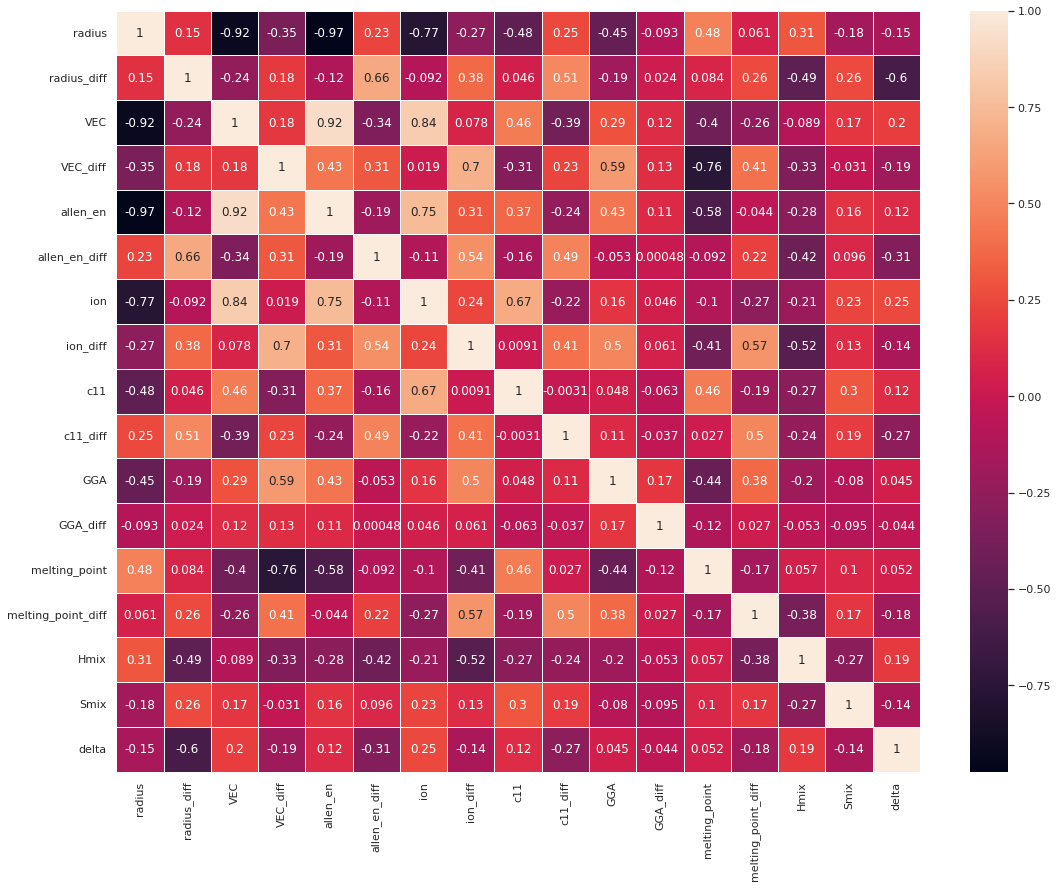

In [7]:
show_correlation_coefficient(data_df=data_df.drop([target_feature],axis = 1),method = "pearson")

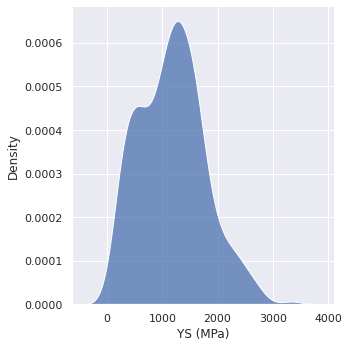

In [8]:
show_distribution_diagram(data_df,target_feature)

In [9]:
cv = KFold(n_splits=5)
tpot_params = {
    "scoring": 'neg_mean_absolute_error',
    "cv": cv,
    "random_state": 1331,
    "verbosity": 3,
    "n_jobs": -1,
    "generations": 30,
    "population_size": 10,
    "max_eval_time_mins": 3
}

auto_sklearn_params = {
    "scoring_functions": [mean_absolute_error],
    "per_run_time_limit": 180,
    "seed": 1331,
    "resampling_strategy_arguments": {'cv': {'folds': 5}},
    "max_models_on_disc":10,
    "n_jobs": -1,
}
tpot = TPOTRegressor(**tpot_params)
auto_sklearn = AutoSklearnRegressor(**auto_sklearn_params)
yield_stress_predict = YieldStressPredict(tpot, auto_sklearn)

In [10]:
compare_frameworks(yield_stress_predict, data_df, target_feature, 0.2, 1,fw_stats_filename,y_predict_stats_filename)

30 operators have been imported by TPOT.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.

Generation 1 - Current Pareto front scores:

-1	-267.85626104489336	ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.05, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=7, ExtraTreesRegressor__n_estimators=100)

Generation 2 - Current Pareto front scores:

-1	-251.79928594612792	ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.05, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=3, ExtraTreesRegressor__n_estimators=100)

Generation 3 - Current Pareto front scores:

-1	-251.79928594612792	ExtraTreesRegressor(input_matri

ValueError: ValueError: Lengths must be equal

In [23]:
from matplotlib.ticker import FuncFormatter

def show_diagram_two_model(filename,number_point,aspect,height):
    result = pd.read_csv(filename)
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    new_result = result
    new_result['MAE'] *= -1
    new_result = new_result.drop([result.columns[2],result.columns[3],result.columns[4]],axis = 1)
    for i in range(2, 5):
        property_name = result.columns[i]
        data = result[property_name]
        df = new_result
        df[property_name] = data
        g = sns.catplot(data=df, kind="point", x='Times', y=property_name, hue='type', ci=None, palette="dark", aspect=aspect, height=aspect)
        ax = g.fig.gca()
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    
    

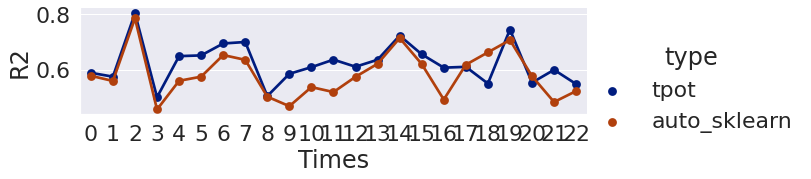

In [24]:
show_diagram_two_model(fw_stats_filename,100,5,5)

In [25]:

sns.set_theme(style="white")

# Load the example mpg dataset
y_stats = pd.read_csv(y_predict_stats_filename)
print(y_stats)
columns = {'y_true':[],
        'y_predict': [],
        'type': []}
df_predict = pd.DataFrame(columns)
df_predict['y_true'].add(y_stats['y_true'])
df_predict['y_predict'].add(y_stats['tpot_predict']) 
df_predict['type'].add(['tpot'] * len(y_stats['tpot_predict']))
df_predict['y_true'].add(y_stats['y_true'])
df_predict['y_predict'].add(y_stats['auto_sklearn_predict'])
df_predict['type'].add(['auto_sklearn'] * len(y_stats['auto_sklearn_predict']))

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="y_true", y="y_predict", hue="type", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df_predict)

    y_true  tpot_predict  auto_sklearn_predict  tpot_error  auto_sklearn_error
0      NaN      1834.485           1860.501060    0.442205            0.442205
1      NaN       468.340            376.450206    0.232474            0.232474
2      NaN      1653.290           1555.483505    0.091281            0.091281
3      NaN      1565.040           1571.509176    0.017581            0.017581
4      NaN      1415.440           1282.815060    0.395897            0.395897
..     ...           ...                   ...         ...                 ...
64     NaN       578.858            449.453711    1.159918            1.159918
65     NaN       924.114            916.593782    0.124892            0.124892
66     NaN      1765.084           1727.346859    0.218989            0.218989
67     NaN      1231.483           1436.777740    0.096491            0.096491
68     NaN      1052.060            958.236481    0.073531            0.073531

[69 rows x 5 columns]


ValueError: ValueError: Lengths must be equal